## Load Data

This dataset [Electricity Load Diagrams 20112014 Data Set](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#) is from UCI Machine Learning Repository.

### Data Set Information:

Data set has no missing values.
Values are in kW of each 15 min. To convert values in kWh values must be divided by 4.
Each column represent one client. Some clients were created after 2011. In these cases consumption were considered zero.
All time labels report to Portuguese hour. However all days present 96 measures (24*4). Every year in March time change day (which has only 23 hours) the values between 1:00 am and 2:00 am are zero for all points. Every year in October time change day (which has 25 hours) the values between 1:00 am and 2:00 am aggregate the consumption of two hours.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# !curl https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip --output LD2011_2014.txt.zip
# !unzip LD2011_2014.txt.zip
# !ls

In [3]:
# url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip'
df = pd.read_csv("LD2011_2014.txt", sep = ';', index_col = 0, dtype=str)

In [4]:
print(df.shape)

(140256, 370)


# Data processing & Pre-Modeling


## Data Cleaning

- Melt the wide data matrix to long data matrix
- Convert index to timestamps, entries to numeric

In [5]:
def preprocessing(dataframe):
    # convert index (timestamp) to a new column
    dataframe = dataframe.reset_index().rename(columns={"index": "timestamp"})

    # unpivot the data
    dataframe = dataframe.melt(id_vars=['timestamp'], var_name='user', value_name='usage_per_15min')
    # fix the timestamp
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'], format = '%Y-%m-%d %H:%M:%S')
    # fix electricity usage
    dataframe['usage_per_15min'] = dataframe['usage_per_15min'].apply(lambda x: str(x).replace(',', '.')).astype(float)

    return dataframe

df = preprocessing(df)

In [6]:
def aggregate_date(dataframe):
    dataframe['date'] = pd.to_datetime((dataframe.timestamp - np.timedelta64(1, 'm')).dt.date)
    dataframe_day = dataframe.groupby(['user', 'date']).sum().reset_index()
    dataframe_day = dataframe_day.rename(columns={'usage_per_15min': 'sum_per_day'})
    dataframe_day['std_per_day'] = dataframe.groupby(['user', 'date']).std().reset_index().usage_per_15min

    return dataframe_day

df_day = aggregate_date(df)
df_day.head()

,user,date,sum_per_day,std_per_day
0,MT_001,2011-01-01,0.0,0.0
1,MT_001,2011-01-02,0.0,0.0
2,MT_001,2011-01-03,0.0,0.0
3,MT_001,2011-01-04,0.0,0.0
4,MT_001,2011-01-05,0.0,0.0


dropping 103832 rows with leading zeros...
user
MT_223    829
MT_347    622
Name: sum_per_day, dtype: int64


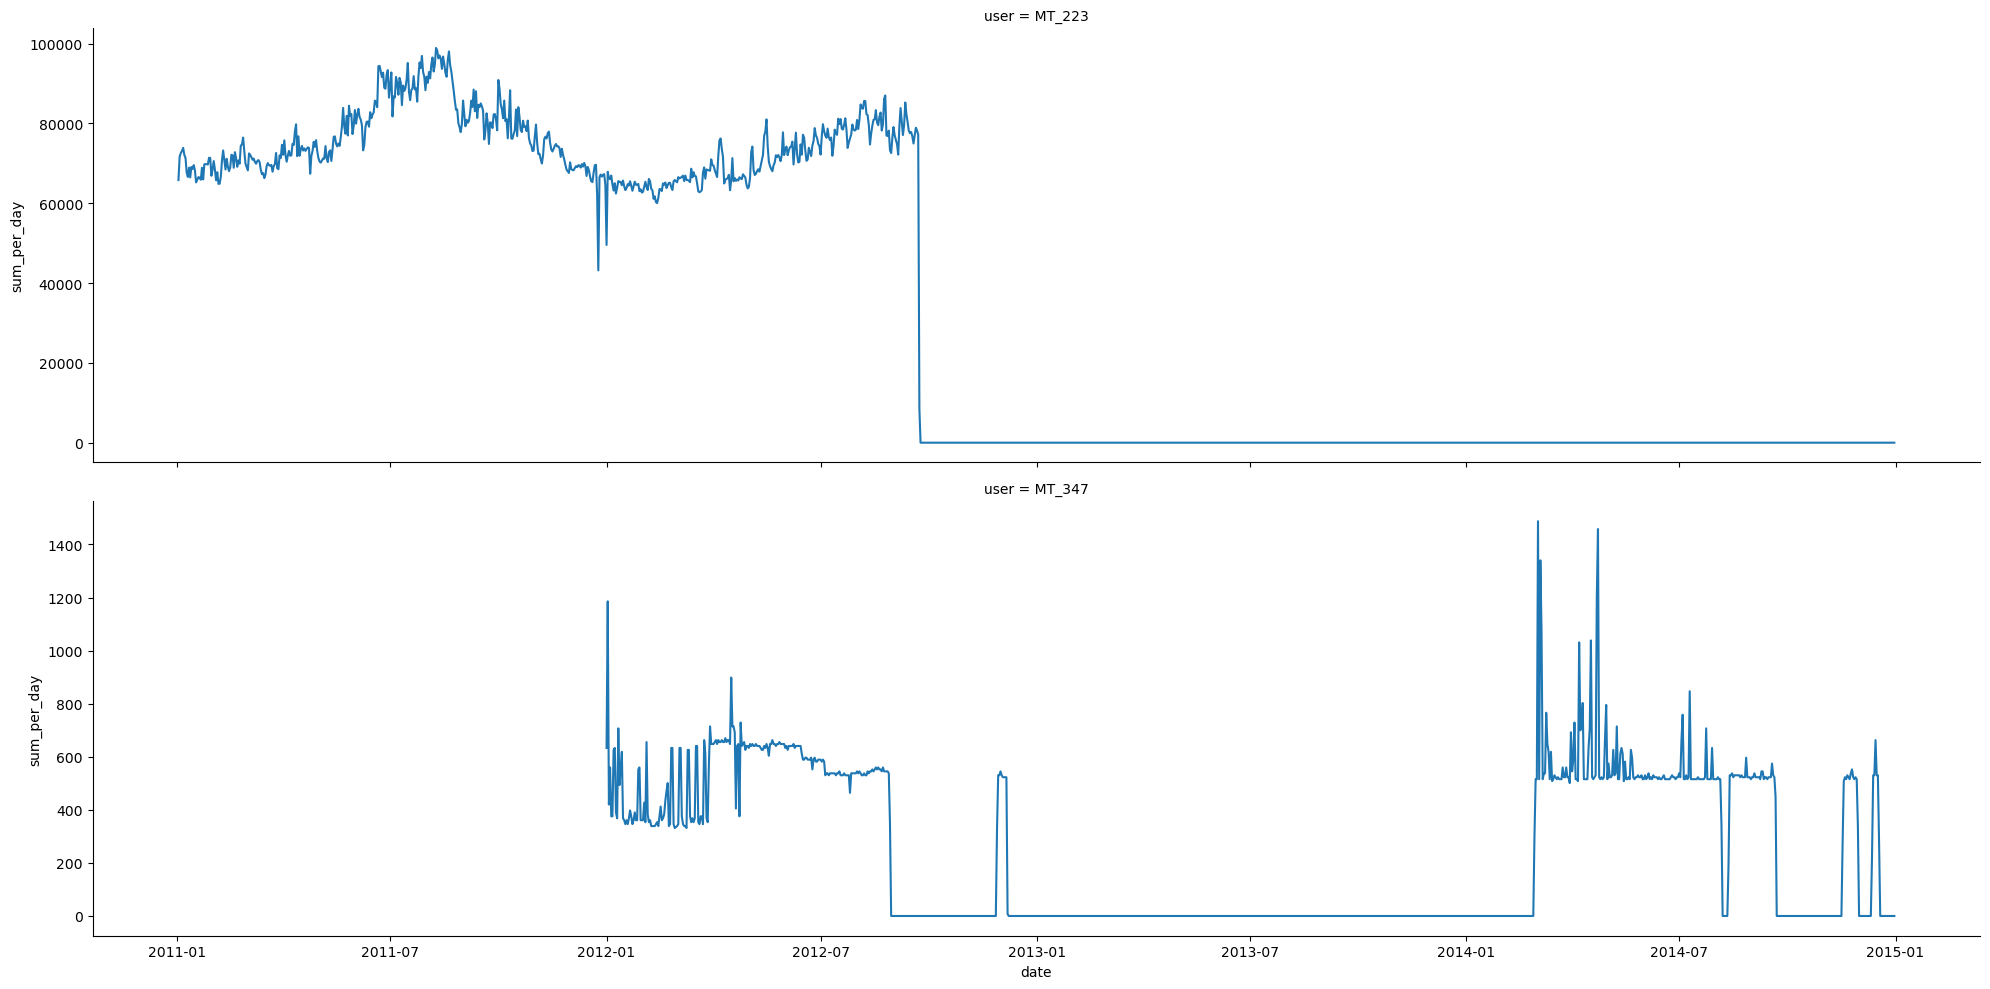

In [7]:
def cleaning(dataframe, threshold=90):
    dataframe = dataframe.copy(deep=True)
    # dataframe = dataframe[dataframe.date.dt.year >= 2012]
    # remove the extra day in leap year
    dataframe = dataframe[dataframe.date != pd.to_datetime('20120229')]

    # find users that are active since 2012
    # active_user = [user for user in dataframe.user.unique() if dataframe[(dataframe.user==user) * (dataframe.date==pd.to_datetime('20120101'))].sum_per_day.item() > 0]
    # dataframe = dataframe[dataframe.user.isin(active_user)]

    def without_leading_consecutive_zeros(dataframe, threshold, by="user", col="sum_per_day"):
        # reference: https://datascience.stackexchange.com/questions/20587/find-the-consecutive-zeros-in-a-dataframe-and-do-a-conditional-replacement
        group = dataframe.groupby(by=by)[col].apply(lambda x: (~((x == x.shift()) & (x == 0))).cumsum())
        mask = dataframe[col].groupby(group).transform('count').lt(threshold)
        mask |= (group != 1)
        return mask

    mask = without_leading_consecutive_zeros(dataframe, threshold)
    print(f'dropping {(~mask).sum()} rows with leading zeros...')
    dataframe = dataframe.loc[mask, :]

    # count 0 usage days
    zero_count = dataframe.groupby('user')['sum_per_day'].apply(lambda x: np.sum(x == 0))
    abnormal = zero_count[zero_count > 370]
    print(abnormal)

    sns.relplot(data=dataframe[dataframe.user.isin(abnormal.index)], 
            x="date", y="sum_per_day", row="user",
            kind="line", aspect=4, facet_kws={'sharey': False})

    dataframe = dataframe[~dataframe.user.isin(abnormal.index)]

    return dataframe

df_day_clean = cleaning(df_day)

## Visualize the Dataset

Have a look on the dataset, visualize if there are any trends or seasonality. 

In [8]:
# select 3 random users 
np.random.seed(32)
random_id = np.random.choice(df_day_clean.user.unique().__len__(), 3)
selected_users = df_day_clean.user.unique()[random_id]
print(f'Selected user ids: {selected_users}')

sample_df = df_day_clean[df_day_clean.user.isin(selected_users)]

Selected user ids: ['MT_216' 'MT_044' 'MT_312']


<AxesSubplot:xlabel='date', ylabel='sum_per_day'>

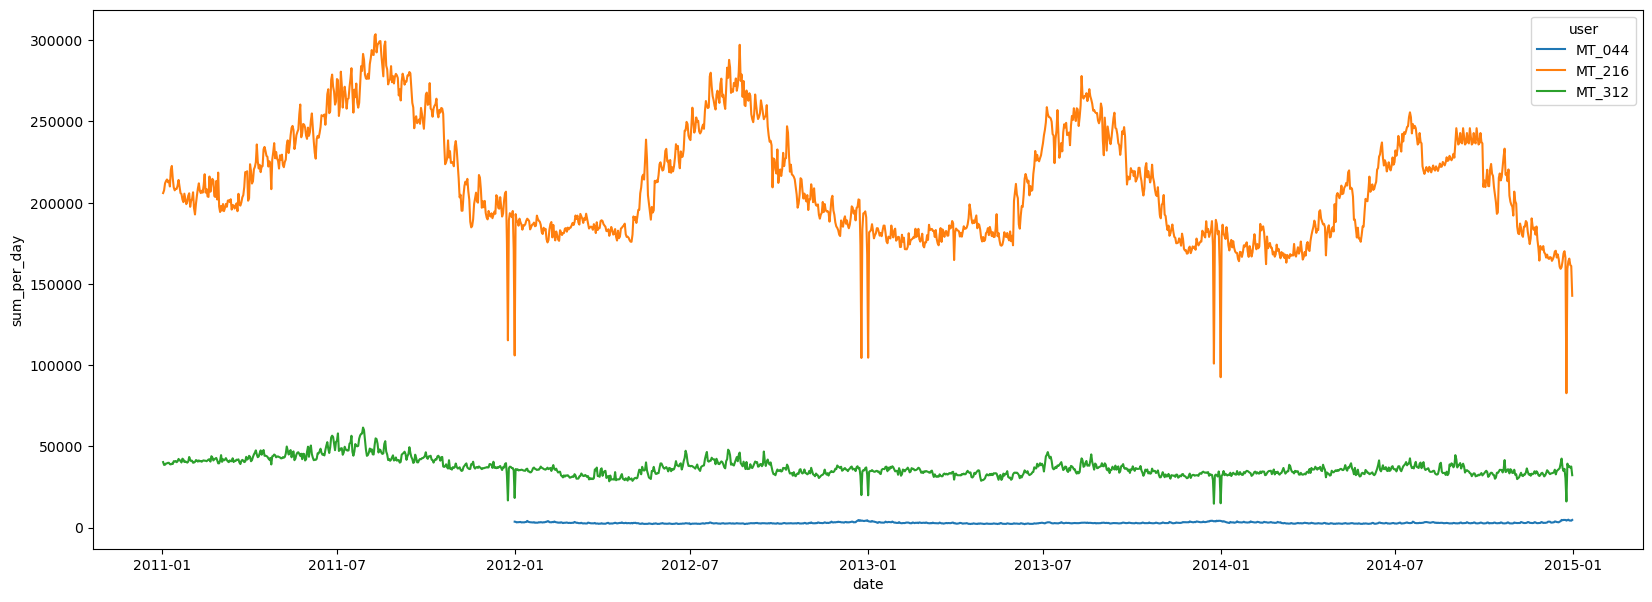

In [9]:
plt.figure(figsize=(20,7))
sns.lineplot(data=sample_df, x="date", y="sum_per_day", hue="user")

# Modeling


In [8]:
# seed all
import tensorflow
import tensorflow as tf
# import torch
import os

SEED = 1345
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True

seed_everything(SEED)

## Deep Learning: LSTM

In [9]:
# Scaler

def scaler_fit_transform(dataframe_raw, train_test_cutoff = pd.to_datetime('20140401')):
    
    dataframe = dataframe_raw.copy(deep=True)

    # normalize = (x - mean)/std
    train_scale_by_user = dataframe.query("date < @train_test_cutoff").groupby("user").sum_per_day.agg(['mean', 'std'])
    train_scale_by_user.rename(columns={'mean': 'overall_mean', 'std': 'overall_std'}, inplace=True)
    dataframe = dataframe.join(train_scale_by_user, on="user", how="left")

    null_stats = train_scale_by_user[(train_scale_by_user == 0).all(axis=1)]
    nan_user = list(set(dataframe.user.unique()) - set(dataframe.query("date < @train_test_cutoff").user.unique()))
    null_stats = pd.concat([null_stats, pd.DataFrame(index=nan_user)])
    null_user = null_stats.index
    
    print(f"Dropped null user with mean/std with zero")
    print(null_stats)    
    dataframe.query("user not in @null_user", inplace=True)

    dataframe.sum_per_day = (dataframe.sum_per_day - dataframe.overall_mean) / dataframe.overall_std
    dataframe.std_per_day = dataframe.std_per_day / dataframe.overall_std

    dataframe.sort_values(by=["user", "date"]).reset_index(drop=True, inplace=True)

    return dataframe

def scaler_inverse_transform(dataframe_raw): 

    dataframe = dataframe_raw.copy(deep=True)

    # inverse normalize
    # x = normalized * std + mean
    dataframe.sum_per_day = dataframe.overall_std * dataframe.sum_per_day + dataframe.overall_mean
    dataframe.sum_per_day_pred = dataframe.overall_std * dataframe.sum_per_day_pred + dataframe.overall_mean
    dataframe.std_per_day = dataframe.std_per_day * dataframe.overall_std
    
    dataframe = dataframe.drop(["overall_mean", "overall_std"], axis=1)
    dataframe.sort_values(by=["user", "date"]).reset_index(drop=True, inplace=True)
    
    return dataframe

Split the dataset to train-val-test which

``` text
Train: {2011-01-01, 2013-06-30}
Val:   {2013-07-01, 2014-03-31}
Test:  {2014-04-01, 2014-12-31}
```

In [10]:
dev_test_cutoff = pd.to_datetime("20140401")
train_val_cutoff = pd.to_datetime("20130701")

print(f"dev_test_cutoff: {dev_test_cutoff}")
print(f"train_val_cutoff: {train_val_cutoff}")

df_day_scaled = scaler_fit_transform(df_day_clean, dev_test_cutoff)
# SHOULD HAVE NO NAN
print(df_day_scaled.isnull().sum())
df_day_scaled["user_id"] = df_day_scaled.apply(lambda row: int("".join(d for d in row.user if d.isdigit())), axis=1)

dev_df = df_day_scaled.query('date < @dev_test_cutoff').copy().reset_index(drop=True)
train_df = dev_df.query('date < @train_val_cutoff').copy().reset_index(drop=True)
val_df = dev_df.query('date >= @train_val_cutoff').copy().reset_index(drop=True)
test_df = df_day_scaled.query('date >= @dev_test_cutoff').copy().reset_index(drop=True)

print(f"dev_df: {dev_df.shape}")
print(f"train_df: {train_df.shape}")
print(f"val_df: {val_df.shape}")
print(f"test_df: {test_df.shape}")

dev_test_cutoff: 2014-04-01 00:00:00
train_val_cutoff: 2013-07-01 00:00:00
Dropped null user with mean/std with zero
        overall_mean  overall_std
MT_178           NaN          NaN
user            0
date            0
sum_per_day     0
std_per_day     0
overall_mean    0
overall_std     0
dtype: int64
dev_df: (332722, 7)
train_df: (236865, 7)
val_df: (95857, 7)
test_df: (100925, 7)


In [11]:
# we need to drop columns so that the dataframe is all numerics

# train_df.drop(["date", "user"], axis=1, inplace=True)
# val_df.drop(["date", "user"], axis=1, inplace=True)
# test_df.drop(["date", "user"], axis=1, inplace=True)
numeric_train_df = train_df.drop(["date", "user"], axis=1)
numeric_val_df = val_df.drop(["date", "user"], axis=1)
numeric_test_df = test_df.drop(["date", "user"], axis=1)

## TensorFlow 

This Notebook will mainly focus on modeling using LSTM (RNN) by Tensorflow 2. We will only take the time-series as input (no other features) with sliding window method.  

In [12]:
from tensorflow import keras
from tensorflow.keras.utils import timeseries_dataset_from_array

# Reference: https://www.tensorflow.org/tutorials/structured_data/time_series

class WindowGenerator():
  def __init__(self, input_width, label_width, shift, 
               sequence_stride=1, batch_size=64, shuffle=True,
               train_df=numeric_train_df, val_df=numeric_val_df, test_df=numeric_test_df,
               input_columns=None, label_columns=None, group_column="user_id"):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the input/label column indices.
    self.input_columns = input_columns
    self.label_columns = label_columns
    self.group_column = group_column
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    self.column_length = len(self.column_indices)

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.sequence_stride = sequence_stride
    self.batch_size = batch_size
    self.shuffle = shuffle

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

  def split_window(self, features):
    # inputs.shape = (BATCH_SIZE, INPUT_SEQUENCE_WIDTH, INPUT_SIZE)
    # inputs.shape = (BATCH_SIZE, LABEL_SEQUENCE_WIDTH, LABEL_SIZE)
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    # slice only input_columns as input
    if self.input_columns is not None:
      inputs = tf.stack(
          [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
          axis=-1)

    # slice only label_columns as label
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def valid_sequence(self, features):
    # Only keep sequence that belongs to the same user
    features.set_shape([self.total_window_size, self.column_length])
    group_index = self.column_indices[self.group_column]
    return features[0, group_index] == features[-1, group_index]

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # data = np.array(data)
    ds = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=self.sequence_stride,
        shuffle=True,
        batch_size=1, 
    )

    # Since we want to filter before batch, the shape of current batch is 
    # (1, WINDOW_SIZE, FEATURE_WIDTH), first squeeze the current batch so 
    # (1, WINDOW_SIZE, FEATURE_WIDTH) => (WINDOW_SIZE, FEATURE_WIDTH), then
    # re-batch to (BATCH_SIZE, WINDOW_SIZE, FEATURE_WIDTH). Then the final
    # output (each batch) contains two parts: inputs, labels.
    ds = ds.map(lambda x: tf.squeeze(x, axis=0))
    ds = ds.filter(self.valid_sequence)
    ds = ds.batch(self.batch_size)
    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def plot(self, model=None, plot_col='sum_per_day', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [day]')


We planned to stick with 30 days (roughly one month) for both input sequence length and output sequence length, which is enough to capture some trends but will not be too expensive to train. 

Below is an example window.

In [13]:
INPUT_WIDTH = 30
LABEL_WIDTH = 30
SHIFT = INPUT_WIDTH 
INPUT_COLUMNS = ["sum_per_day"]
LABEL_COLUMNS = ["sum_per_day"]
window = WindowGenerator(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT, 
                         input_columns=INPUT_COLUMNS, label_columns=LABEL_COLUMNS)
window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['sum_per_day']

In [14]:
window.train.element_spec

(TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 30, 1), dtype=tf.float32, name=None))

In [15]:
for example_inputs, example_labels in window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 30, 1)
Labels shape (batch, time, features): (64, 30, 1)


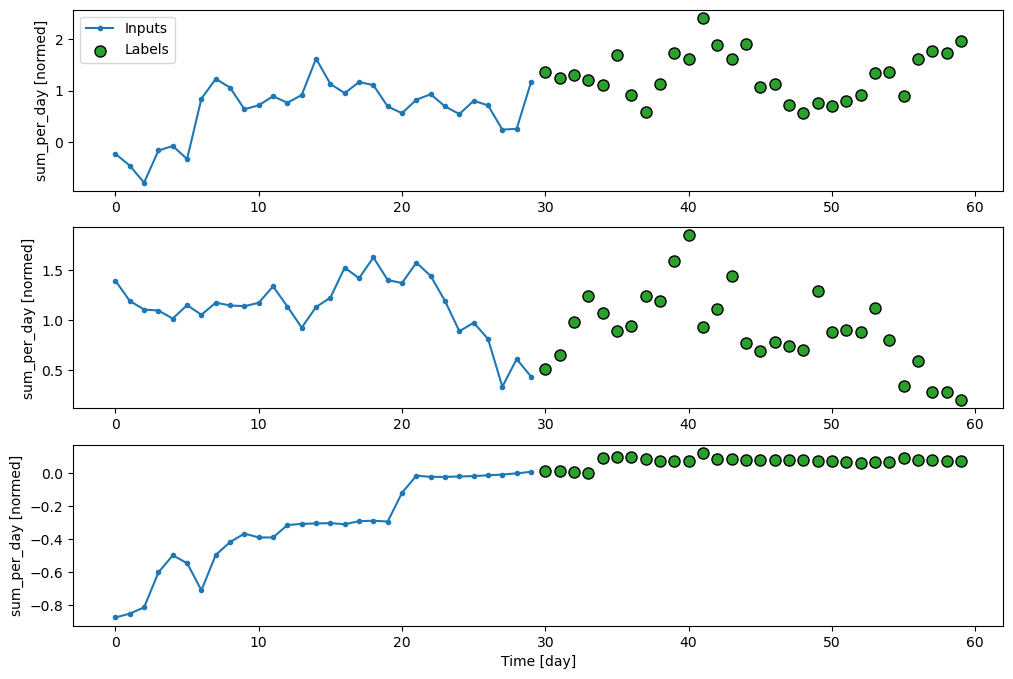

In [16]:
window.plot()

Training optimizer/callbacks

In [17]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [18]:
def plot_history(history):
  err = history.history['mean_absolute_error']
  val_err = history.history['val_mean_absolute_error']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(err, label='Training Error (MAE)')
  plt.plot(val_err, label='Validation ERROR (MAE)')
  plt.legend(loc='lower right')
  plt.ylabel('Mean Absolute Error')
  plt.title('Training and Validation Error (MAE)')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Mean Squared Error')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()


### Model Building

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape, LSTM

#### Simple Model 

Start with a simple model which the output is 1 day after 30 days of input. 

In [23]:
single_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=1, shift=1, 
        input_columns=INPUT_COLUMNS, label_columns=LABEL_COLUMNS)
single_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30]
Label column name(s): ['sum_per_day']

In [24]:
for example_inputs, example_labels in single_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 30, 1)
Labels shape (batch, time, features): (64, 1, 1)


In [25]:
linear_model = Sequential([
    # Shape: (time, features) => (time*features)
    Flatten(),
    Dense(units=32, activation="relu"),
    Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    Reshape([1, -1]),
])

Epoch 1/20
3543/3543 [==============================] - 45s 12ms/step - loss: 0.1911 - mean_absolute_error: 0.2925 - val_loss: 0.1767 - val_mean_absolute_error: 0.2766
Epoch 2/20
3543/3543 [==============================] - 31s 9ms/step - loss: 0.1698 - mean_absolute_error: 0.2759 - val_loss: 0.1711 - val_mean_absolute_error: 0.2716
Epoch 3/20
3543/3543 [==============================] - 28s 8ms/step - loss: 0.1657 - mean_absolute_error: 0.2720 - val_loss: 0.1683 - val_mean_absolute_error: 0.2694
Epoch 4/20
3543/3543 [==============================] - 27s 8ms/step - loss: 0.1621 - mean_absolute_error: 0.2682 - val_loss: 0.1659 - val_mean_absolute_error: 0.2672
Epoch 5/20
3543/3543 [==============================] - 31s 9ms/step - loss: 0.1597 - mean_absolute_error: 0.2659 - val_loss: 0.1642 - val_mean_absolute_error: 0.2657
Epoch 6/20
3543/3543 [==============================] - 28s 8ms/step - loss: 0.1582 - mean_absolute_error: 0.2644 - val_loss: 0.1616 - val_mean_absolute_error: 0.26

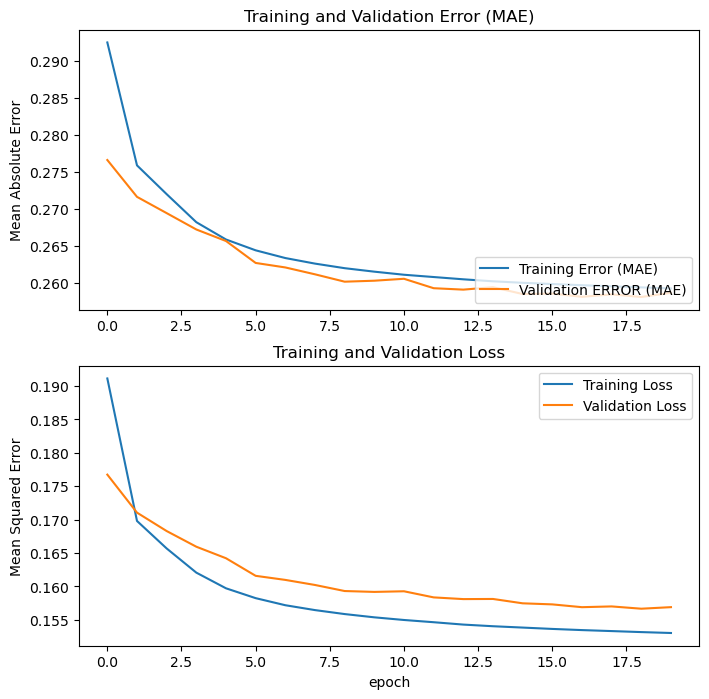

In [26]:
linear_history = compile_and_fit(linear_model, single_window)
linear_val_performance = linear_model.evaluate(single_window.val)
linear_test_performance = linear_model.evaluate(single_window.test)

plot_history(linear_history)

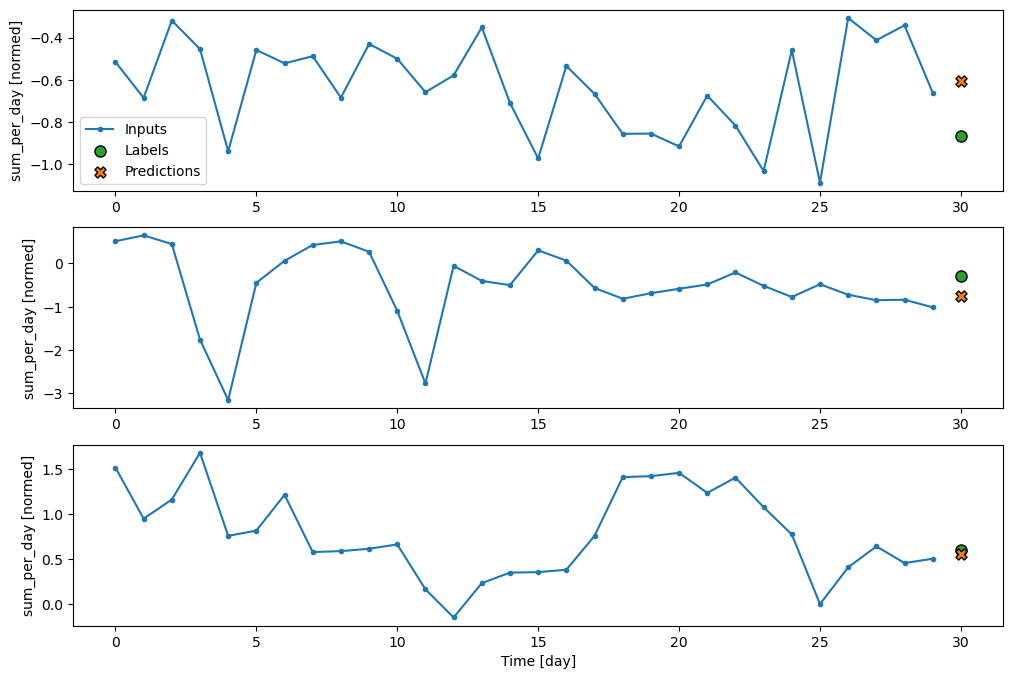

In [27]:
single_window.plot(linear_model)

### Single LSTM Model

Now let's see how a basic LSTM work if we are moving one step ahead, but now returning a sequence with same length.

In [28]:
wide_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=INPUT_WIDTH, shift=1,
    input_columns=INPUT_COLUMNS, label_columns=LABEL_COLUMNS)
wide_window

Total window size: 31
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]
Label column name(s): ['sum_per_day']

In [29]:
for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 30, 1)
Labels shape (batch, time, features): (64, 30, 1)


In [30]:
lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    Dense(units=1)
])

Epoch 1/20
3543/3543 [==============================] - 35s 9ms/step - loss: 0.2249 - mean_absolute_error: 0.3136 - val_loss: 0.2085 - val_mean_absolute_error: 0.2948
Epoch 2/20
3543/3543 [==============================] - 28s 8ms/step - loss: 0.1858 - mean_absolute_error: 0.2841 - val_loss: 0.2005 - val_mean_absolute_error: 0.2881
Epoch 3/20
3543/3543 [==============================] - 29s 8ms/step - loss: 0.1805 - mean_absolute_error: 0.2798 - val_loss: 0.1968 - val_mean_absolute_error: 0.2849
Epoch 4/20
3543/3543 [==============================] - 29s 8ms/step - loss: 0.1777 - mean_absolute_error: 0.2774 - val_loss: 0.1948 - val_mean_absolute_error: 0.2831
Epoch 5/20
3543/3543 [==============================] - 29s 8ms/step - loss: 0.1758 - mean_absolute_error: 0.2759 - val_loss: 0.1934 - val_mean_absolute_error: 0.2820
Epoch 6/20
3543/3543 [==============================] - 29s 8ms/step - loss: 0.1743 - mean_absolute_error: 0.2748 - val_loss: 0.1926 - val_mean_absolute_error: 0.281

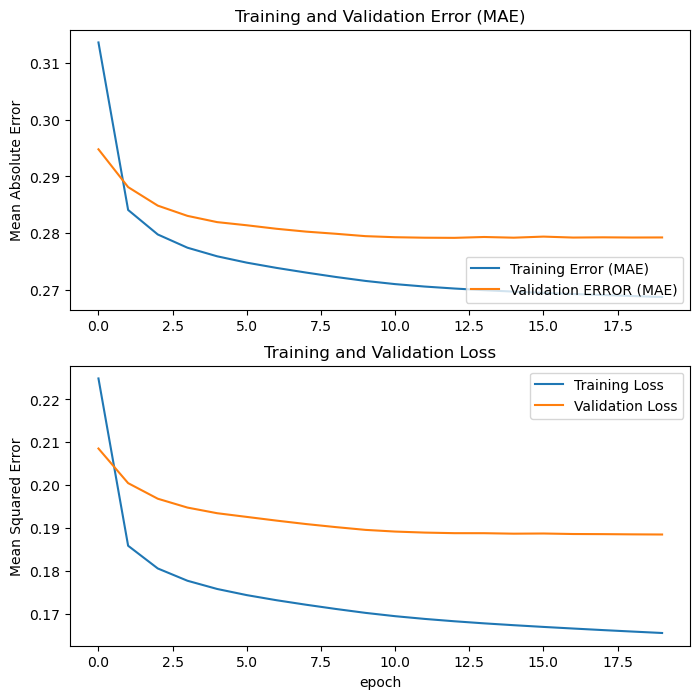

In [31]:
lstm_history = compile_and_fit(lstm_model, wide_window)
lstm_val_performance = lstm_model.evaluate(wide_window.val)
lstm_test_performance = lstm_model.evaluate(wide_window.test)

plot_history(lstm_history)

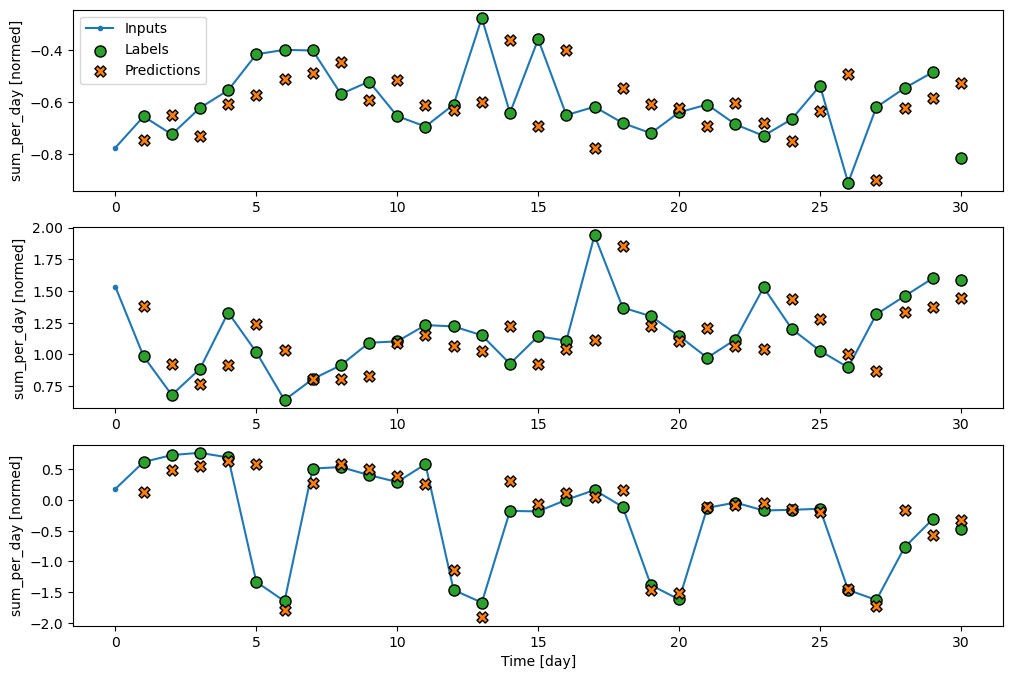

In [33]:
wide_window.plot(lstm_model)

### Multi LSTM Model

From the example prediction plot above, we can see that LSTM is capturing trends, let's try if we are forecasting 30 days ahead.

In [20]:
multi_wide_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=SHIFT,
    input_columns=INPUT_COLUMNS, label_columns=LABEL_COLUMNS)
multi_wide_window

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['sum_per_day']

In [21]:
for example_inputs, example_labels in multi_wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (64, 30, 1)
Labels shape (batch, time, features): (64, 30, 1)


In [25]:
num_features = len(INPUT_COLUMNS)
multi_lstm_model = Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    Dense(LABEL_WIDTH*num_features,
          kernel_initializer=tf.keras.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    Reshape([LABEL_WIDTH, num_features])
])

Epoch 1/20
3390/3390 [==============================] - 24s 7ms/step - loss: 0.4480 - mean_absolute_error: 0.4786 - val_loss: 0.4639 - val_mean_absolute_error: 0.4879
Epoch 2/20
3390/3390 [==============================] - 23s 7ms/step - loss: 0.4055 - mean_absolute_error: 0.4513 - val_loss: 0.4519 - val_mean_absolute_error: 0.4802
Epoch 3/20
3390/3390 [==============================] - 22s 6ms/step - loss: 0.3951 - mean_absolute_error: 0.4436 - val_loss: 0.4501 - val_mean_absolute_error: 0.4759
Epoch 4/20
3390/3390 [==============================] - 22s 6ms/step - loss: 0.3882 - mean_absolute_error: 0.4387 - val_loss: 0.4435 - val_mean_absolute_error: 0.4723
Epoch 5/20
3390/3390 [==============================] - 22s 6ms/step - loss: 0.3827 - mean_absolute_error: 0.4349 - val_loss: 0.4443 - val_mean_absolute_error: 0.4710
Epoch 6/20
1239/1239 [==============================] - 5s 4ms/step - loss: 0.7140 - mean_absolute_error: 0.4999


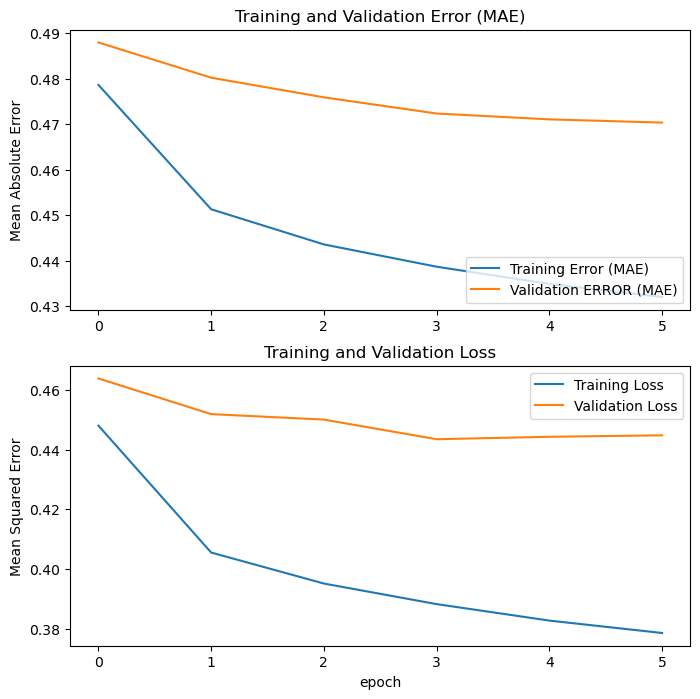

In [26]:
multi_lstm_history = compile_and_fit(multi_lstm_model, multi_wide_window)
multi_lstm_val_performance = multi_lstm_model.evaluate(multi_wide_window.val)
multi_lstm_test_performance = multi_lstm_model.evaluate(multi_wide_window.test)

plot_history(multi_lstm_history)

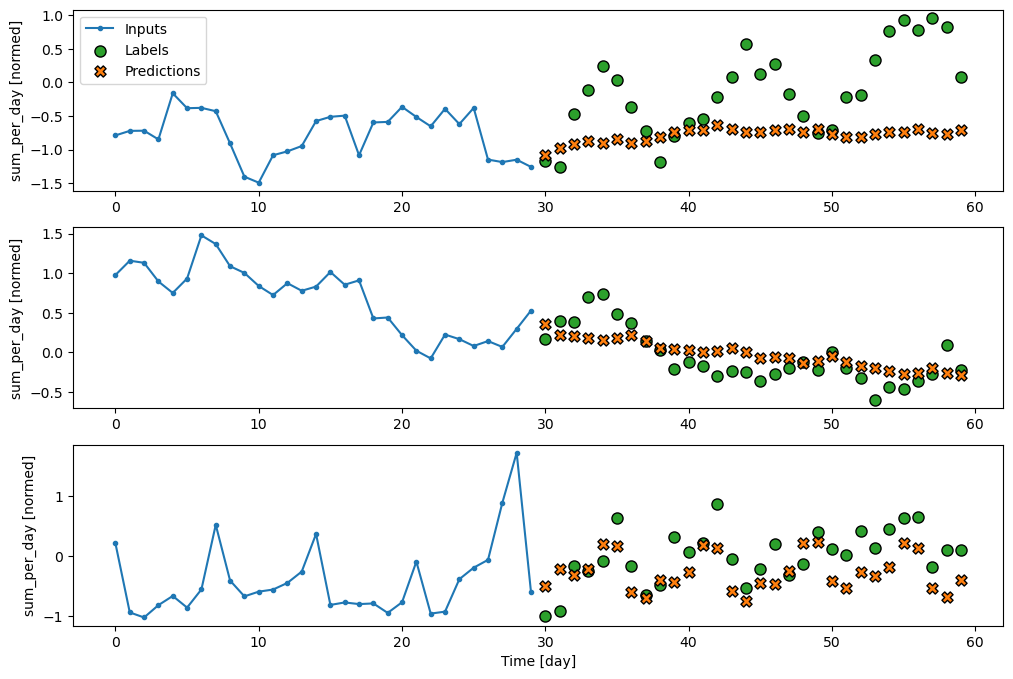

In [27]:
multi_wide_window.plot(multi_lstm_model)

### Evaluation

Evaluate window: 
- 3 months after
- 6 months after
- 9 months after
  
Input has only one set, 30 days before the start of testing set. 
In our final LSTM model, we have input length 30 days, output length 30 days. Suppose that input starts at `t=0`, then with input `[0, 1, ..., 28, 29]`, output `[30, 31, ... 58, 59]`. So the output of current window will be input of next window. 

In [28]:
# To make a single batch for evaluation input (30 days before test start date)
def make_eval_batch(dataframe, test_start_date, sequence_length):
    input_window_date = pd.to_datetime(test_start_date - np.timedelta64(sequence_length, 'D'))
    print(f'We will take inputs from {input_window_date} to {test_start_date}')
    window_dataframe = dataframe.query("@input_window_date <= date and date < @test_start_date")\
        .pivot_table(index="date", columns="user", values="sum_per_day")
    return window_dataframe

In [29]:
eval_window_df = make_eval_batch(dev_df, dev_test_cutoff, INPUT_WIDTH)
eval_window_df

We will take inputs from 2014-03-02 00:00:00 to 2014-04-01 00:00:00


user,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
date,,,,,,,,,,,,,,,,,,,,,
2014-03-02,-0.704615,-1.512964,-0.270924,1.989532,0.753205,0.804189,-0.062437,-1.063652,0.415564,0.365410,...,-1.038693,-0.879645,-0.677251,-1.382127,-1.196462,-1.351672,-0.736273,-1.687161,-1.583472,-1.118935
2014-03-03,-0.474700,-1.309601,-0.282176,1.530322,1.600218,0.943798,-0.065966,0.432539,1.193814,0.312683,...,-1.050606,-0.979542,-1.251296,-1.428477,-1.225587,0.152438,0.085769,0.285778,-0.829742,-0.527848
2014-03-04,-0.457014,-1.401505,-0.277848,1.795821,1.771239,1.271574,-0.023618,-0.631227,-0.176364,0.314821,...,-1.276187,-0.964419,-1.147660,-1.401130,-1.127933,-0.938603,0.066722,0.301277,-0.761811,-0.521972
2014-03-05,-0.558076,-1.331111,-0.276117,1.262545,1.046674,1.113756,-0.130371,-0.683118,-0.437213,0.126003,...,-1.095475,-0.891519,-1.275905,-1.421293,-1.038846,0.043559,0.228162,0.478951,-0.694523,-0.256982
2014-03-06,-0.664190,-1.282226,-0.276983,1.392446,0.539681,0.382328,-0.183306,-1.189920,-0.550439,-0.185368,...,-1.034206,-0.807171,-1.211783,-0.701943,-1.042273,-0.911664,0.193038,0.648309,-0.429865,0.051047
2014-03-07,-0.593447,-1.401505,-0.279579,1.019836,0.457712,0.348944,-0.155956,-0.728090,-0.494543,-0.024339,...,-0.808935,-0.952384,-0.825749,-0.615732,-1.179330,0.300604,0.438661,0.682331,-0.142087,-0.001686
2014-03-08,-0.775358,-1.116016,-0.265731,1.530322,0.277583,-0.329878,-0.187717,-0.653713,-0.963213,-0.532365,...,-1.141117,-0.940829,-0.682371,-0.661619,-1.174190,-0.004708,-0.256322,-1.330679,-0.813901,-0.624355
2014-03-09,-0.775358,-1.266582,-0.270924,0.912725,0.206745,-0.612130,-0.154191,-1.950989,-1.047774,-0.753246,...,-1.423480,-0.879591,-0.754442,-0.685721,-1.215878,-0.671455,-0.826474,-1.602860,-1.524603,-1.204572
2014-03-10,-0.487333,-1.247028,-0.282176,0.504792,-0.111011,-0.276260,-0.258297,-1.625805,-0.871485,0.302708,...,-1.472990,-0.855895,-1.187403,-0.653508,-0.605975,0.571120,0.090139,0.197697,-0.611679,-0.309716


In [30]:
def eval_input_transform(X):
    # input: X is a wide dataframe/numpy matrix
    #        columns are users, rows are timestamps
    #        X.shape = (SEQUENCE_LENGTH, NUM_USERS)
    # Return the input with shape (NUM_USERS, SEQUENCE_LENGTH, 1)
    # So its like a single batch but with NUM_USERS as BATCH_SIZE
    return X.T[:, :, np.newaxis]

def eval_input_inverse_transform(X):
    # input: X is a input batch
    #        X.shape = (NUM_USERS, SEQUENCE_LENGTH, 1)
    # Return the input with shape (SEQUENCE_LENGTH, NUM_USERS)
    # So its like a wide dataframe/numpy matrix 
    return np.squeeze(X, axis=2).T

In [31]:
def make_eval_dataframe(dataframe, model, start_date=pd.to_datetime("20140401"), end_date=pd.to_datetime("20141231"), periods=INPUT_WIDTH):
    ''' Suppose we have initial data 30 days before test start date, we want to 
    iterate so that the output from current window will be the input of next 
    window. This function predicts every 30 days until the test end date.

    Inputs: 
        dataframe  -- a given that have initial n days of data
        model      -- a model to pad prediction values to dataframe
        start_date -- should match test_df start date
        end_date   -- should match test_df end date
        perids     -- sequence length for each prediction (n)
    Returns:
        dataframe  -- dataframe padded with predictions till end_date
    '''

    X = dataframe.iloc[0:periods, :].to_numpy()
    X = eval_input_transform(X)
    last = pd.to_datetime(start_date - np.timedelta64(1, 'D'))
    
    while last < end_date:
        first = pd.to_datetime(last + np.timedelta64(1, 'D'))
        current_window_date_index = pd.date_range(first, periods=periods, freq="D")
        last = current_window_date_index[-1]
        print(f"first at {first}, last at {last}")
        X_new = model(X)
        dataframe = pd.concat([
            dataframe, 
            pd.DataFrame(data=eval_input_inverse_transform(X_new), 
                         index=current_window_date_index,
                         columns=dataframe.columns)
        ])
        X = X_new

    return dataframe[start_date:end_date]


In [32]:
eval_window_df = make_eval_dataframe(eval_window_df, multi_lstm_model)
eval_window_df

first at 2014-04-01 00:00:00, last at 2014-04-30 00:00:00
first at 2014-05-01 00:00:00, last at 2014-05-30 00:00:00
first at 2014-05-31 00:00:00, last at 2014-06-29 00:00:00
first at 2014-06-30 00:00:00, last at 2014-07-29 00:00:00
first at 2014-07-30 00:00:00, last at 2014-08-28 00:00:00
first at 2014-08-29 00:00:00, last at 2014-09-27 00:00:00
first at 2014-09-28 00:00:00, last at 2014-10-27 00:00:00
first at 2014-10-28 00:00:00, last at 2014-11-26 00:00:00
first at 2014-11-27 00:00:00, last at 2014-12-26 00:00:00
first at 2014-12-27 00:00:00, last at 2015-01-25 00:00:00


user,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2014-04-01,-0.459890,-1.339772,-0.273906,1.213972,0.921965,0.334186,-0.226136,-1.564472,-0.371388,-0.393459,...,-1.398538,-0.914834,-1.400814,-0.687031,-1.163082,-0.305248,0.305259,0.752710,-0.539569,-0.054463
2014-04-02,-0.480548,-1.323181,-0.282185,1.266141,0.752670,0.207195,-0.266735,-1.293019,-0.456705,-0.506552,...,-1.262183,-0.911736,-1.265180,-0.650984,-1.151422,-0.323907,0.368412,0.646610,-0.510640,-0.062760
2014-04-03,-0.569424,-1.283760,-0.248295,1.327336,0.756380,0.234417,-0.234107,-1.000088,-0.343438,-0.414519,...,-1.173750,-0.871041,-1.147452,-0.613198,-1.124585,-0.270702,0.411399,0.601678,-0.375795,0.058673
2014-04-04,-0.648874,-1.211694,-0.256522,1.419082,0.678626,0.224498,-0.214758,-0.959439,-0.356418,-0.364164,...,-0.992928,-0.823783,-1.009176,-0.583055,-1.117393,-0.247936,0.522231,0.596593,-0.237817,0.124412
2014-04-05,-0.638420,-1.163161,-0.243245,1.325032,0.584575,-0.028556,-0.182256,-1.341410,-0.493129,-0.513122,...,-0.970939,-0.782529,-0.909211,-0.562907,-1.109862,-0.522674,-0.111891,-1.067024,-1.063669,-0.128359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,-0.196855,-0.226702,-0.183035,-0.022703,-0.009270,0.071258,-0.179016,-0.294000,-0.201728,-0.202055,...,-0.228318,-0.210996,-0.239641,-0.194338,-0.220604,-0.151655,-0.143760,-1.125355,-1.126536,-0.118860
2014-12-28,-0.217952,-0.243380,-0.204011,-0.049822,-0.037148,0.043148,-0.199753,-0.264085,-0.221942,-0.222121,...,-0.240457,-0.229176,-0.246976,-0.215168,-0.239450,-0.176241,-0.151786,-1.596466,-1.608921,-0.144594
2014-12-29,-0.185597,-0.212803,-0.171647,-0.006352,0.006150,0.090198,-0.166809,-0.208854,-0.191246,-0.191365,...,-0.208368,-0.198012,-0.208492,-0.184799,-0.210259,-0.143020,-0.115517,0.017696,-0.000979,-0.109688
2014-12-30,-0.199825,-0.228614,-0.188693,-0.026128,-0.014437,0.069351,-0.184127,-0.234406,-0.207758,-0.207907,...,-0.227353,-0.214447,-0.221643,-0.202484,-0.226588,-0.160576,-0.151479,0.336261,0.318035,-0.129353


In [33]:
# convert to long dataframe for merging
eval_long_df = eval_window_df\
    .reset_index().rename(columns={"index": "date"})\
    .melt(id_vars=["date"], var_name='user', value_name='sum_per_day_pred')
eval_long_df

,date,user,sum_per_day_pred
0,2014-04-01,MT_001,-0.459890
1,2014-04-02,MT_001,-0.480548
2,2014-04-03,MT_001,-0.569424
3,2014-04-04,MT_001,-0.648874
4,2014-04-05,MT_001,-0.638420
...,...,...,...
100920,2014-12-27,MT_370,-0.118860
100921,2014-12-28,MT_370,-0.144594
100922,2014-12-29,MT_370,-0.109688
100923,2014-12-30,MT_370,-0.129353


In [34]:
eval_long_df = eval_long_df.merge(test_df, on=["date", "user"]).dropna(axis=0)
eval_long_df

,date,user,sum_per_day_pred,sum_per_day,std_per_day,overall_mean,overall_std,user_id
0,2014-04-01,MT_001,-0.459890,-0.424169,0.005650,5.290423e+02,502.281950,1
1,2014-04-02,MT_001,-0.480548,-0.588394,0.003678,5.290423e+02,502.281950,1
2,2014-04-03,MT_001,-0.569424,-0.570708,0.004139,5.290423e+02,502.281950,1
3,2014-04-04,MT_001,-0.648874,0.207466,0.014356,5.290423e+02,502.281950,1
4,2014-04-05,MT_001,-0.638420,-0.729880,0.001821,5.290423e+02,502.281950,1
...,...,...,...,...,...,...,...,...
100920,2014-12-27,MT_370,-0.118860,-0.421793,0.003377,1.594567e+06,367989.068705,370
100921,2014-12-28,MT_370,-0.144594,-0.104804,0.004907,1.594567e+06,367989.068705,370
100922,2014-12-29,MT_370,-0.109688,0.573683,0.004506,1.594567e+06,367989.068705,370
100923,2014-12-30,MT_370,-0.129353,0.741726,0.003245,1.594567e+06,367989.068705,370


In [35]:
# inverse_transform = scale back data to calculate error
eval_long_df_raw = scaler_inverse_transform(eval_long_df)
eval_long_df_raw

,date,user,sum_per_day_pred,sum_per_day,std_per_day,user_id
0,2014-04-01,MT_001,2.980481e+02,3.159898e+02,2.838116,1
1,2014-04-02,MT_001,2.876716e+02,2.335025e+02,1.847438,1
2,2014-04-03,MT_001,2.430309e+02,2.423858e+02,2.079090,1
3,2014-04-04,MT_001,2.031246e+02,6.332487e+02,7.210840,1
4,2014-04-05,MT_001,2.083757e+02,1.624365e+02,0.914497,1
...,...,...,...,...,...,...
100920,2014-12-27,MT_370,1.550827e+06,1.439351e+06,1242.717435,370
100921,2014-12-28,MT_370,1.541358e+06,1.556000e+06,1805.675897,370
100922,2014-12-29,MT_370,1.554202e+06,1.805676e+06,1658.016491,370
100923,2014-12-30,MT_370,1.546966e+06,1.867514e+06,1194.166998,370


We will use Mean Absolute Percentage Error (MAPE) to evaluate the performance of our final model.

*Note: MAPE is not in the range [0,100]*

In [40]:
from sklearn.metrics import mean_absolute_percentage_error

# eval_cutoff = [pd.to_datetime(dev_test_cutoff + np.timedelta64(n, "M")) for n in [3, 6, 9]]
eval_cutoff = pd.date_range(dev_test_cutoff, periods=10, freq="1MS", inclusive="right")
rolling_eval_cutoff = pd.date_range(dev_test_cutoff, pd.to_datetime("2015-01-01"), freq="1D", inclusive="right")
rolling_performance = []

for cutoff in rolling_eval_cutoff:
    y_true = eval_long_df_raw.query("date < @cutoff").sum_per_day
    y_pred = eval_long_df_raw.query("date < @cutoff").sum_per_day_pred
    error = mean_absolute_percentage_error(y_true, y_pred)
    rolling_performance.append(error)
    if (cutoff in eval_cutoff):
        print(f"Evaluating from {dev_test_cutoff} to {cutoff}...")
        print(f"Testing Set MAPE: {error:.4f}")

Evaluating from 2014-04-01 00:00:00 to 2014-05-01 00:00:00...
Testing Set MAPE: 0.3324
Evaluating from 2014-04-01 00:00:00 to 2014-06-01 00:00:00...
Testing Set MAPE: 0.3803
Evaluating from 2014-04-01 00:00:00 to 2014-07-01 00:00:00...
Testing Set MAPE: 0.4164
Evaluating from 2014-04-01 00:00:00 to 2014-08-01 00:00:00...
Testing Set MAPE: 0.3848
Evaluating from 2014-04-01 00:00:00 to 2014-09-01 00:00:00...
Testing Set MAPE: 0.4951
Evaluating from 2014-04-01 00:00:00 to 2014-10-01 00:00:00...
Testing Set MAPE: 0.4443
Evaluating from 2014-04-01 00:00:00 to 2014-11-01 00:00:00...
Testing Set MAPE: 0.4042
Evaluating from 2014-04-01 00:00:00 to 2014-12-01 00:00:00...
Testing Set MAPE: 223241516716967.3750
Evaluating from 2014-04-01 00:00:00 to 2015-01-01 00:00:00...
Testing Set MAPE: 83470877092241328.0000


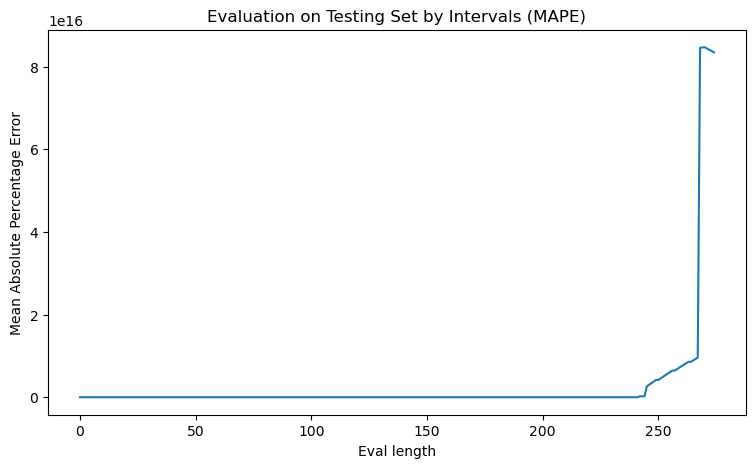

In [41]:
plt.figure(figsize=(9,5))
plt.plot(range(len(rolling_performance)), rolling_performance)
plt.xlabel("Eval length")
plt.ylabel("Mean Absolute Percentage Error")
plt.title("Evaluation on Testing Set by Intervals (MAPE)")
plt.show()

:)